In [ ]:
pip install tensorflow
pip install requests
pip install pandas
pip install matplotlib
pip install torch
pip install plotly
pip install scikit-learn
pip install seaborn

In [ ]:
pip install seaborn

In [1]:
import pandas as pd
import requests
from datetime import datetime
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import json
import sqlite3
import os

In [2]:
def merge_json_objects(obj1, obj2):
    merged_data = {}

    #add ojb1 into holding dict. if key is found in both, merge them then add
    for key, value in obj1.items():
        if key in obj2:
            merged_data[key] = value+obj2[key]
        else:
            merged_data[key] = value

    #add obj2 into holding dict only if key not in obj1
    for key, value in obj2.items():
        if key not in merged_data:
            merged_data[key] = value
            
    return merged_data

In [3]:
class Alpaca:
    def __init__(self, apiKey, apiSecret):
        self.apiKey = apiKey
        self.apiSecret = apiSecret
        
    def api_call(self, url, next_page_token=None):
        # Make a request to the stock price endpoint
        apiKey = self.apiKey
        apiSecret = self.apiSecret
        headers = {
            "accept": "application/json",
            "APCA-API-KEY-ID": apiKey,
            "APCA-API-SECRET-KEY": apiSecret
        }
        response = requests.get(url+next_page_token, headers=headers)
        
        # Check if the response is successful
        if response.status_code == 200:
            # Parse the JSON response
            json_data = response.json()
            bars = json_data['bars']
            # Extract stock data from the current page
            current_page_data = {key: bars[key] for key in bars.keys()}
            # Check if there is a next page
            next_page_token = json_data.get('next_page_token')
            if next_page_token is not None:
                # Recursively fetch and merge the next page data
                next_page_data = self.api_call(url, '&page_token='+next_page_token)
                current_page_data = merge_json_objects(current_page_data, next_page_data)
    
            return current_page_data
    
        else:
            # Handle the case where the API request was not successful
            print(f"Error: {response.status_code}")
            return None


    def get_historic_bars(self, type, symbols, queryParams):
        if type == "crypto":
            base_url = "https://data.alpaca.markets/v1beta3/crypto/us/bars?"

        elif type == "stock":
            base_url = "https://data.alpaca.markets/v2/stocks/bars?"
    
        #add stock symbols to url
        base_url += 'symbols='
        for symbol in symbols:
            base_url += symbol + "%2C";
            base_url[:-3]
    
        #add params to urls
        for key, value in queryParams.items():
            base_url += "&";
            base_url += key;
            base_url += "=";
            base_url += value;
    
        #get merged price data
        results = self.api_call(base_url, '')
    
        #create list of symbols. FIXME: this could probably use the symbols param. dont know which is faster
        symbols = list(results.keys())
        #create empty dict to hold each symbols data
        tables = {}
        for symbol in symbols:
            #get specific symbol's data
            data = results[symbol]
            
            # Convert timestamp strings to datetime objects
            for point in data:
                #FIXME: make sure every endpoint includes 't' measure
                point["t"] = datetime.strptime(point["t"], "%Y-%m-%dT%H:%M:%SZ")
            
            # Create a Pandas DataFrame
            df = pd.DataFrame(data)
                
                
            # FIXME: This is not needed in prod. Wasted computation. Not agnostic
            df.rename(columns={'c': 'close', 'h':'high', 'l':'low', 'n':'trade_count', 'o':'open', 't':'timestamp', 'v':'bar_volume', 'vw':'price_volume_weighted'}, inplace=True)
            df.set_index('timestamp', inplace= True)
        
            # add df to dictionary of dfs
            tables[symbol] = df

        return tables




In [4]:
def create_MACD(data, config):
    shortPeriod = config['shortPeriod']
    longPeriod = config['longPeriod']
    signalPeriod = config['signalPeriod']

    #Calculate short and long ewma used to calculate the final macd
    macdShort=pd.Series(data['open'].ewm(span=shortPeriod, min_periods=1, adjust=False).mean())
    macdLong=pd.Series(data['open'].ewm(span=longPeriod, min_periods=1, adjust=False).mean())
    macd = pd.Series(macdShort - macdLong, name='MACD')
    signal = pd.Series(macd.ewm(span=signalPeriod, min_periods=1, adjust=False).mean())
    crossover = macd-signal
    indicator = pd.concat([data, crossover], axis=1)
    return indicator
    

def create_RSI(data, config):
    period = config['period']
    price_change=pd.Series(data['open'].diff())

    # Calculate the average gain and average loss over a x-day period
    gain=pd.Series(price_change.apply(lambda x: x if x > 0 else 0))
    loss=pd.Series(price_change.apply(lambda x: abs(x) if x < 0 else 0))
    avg_gain=pd.Series(gain.rolling(window=period, min_periods=1).mean())
    avg_loss=pd.Series(loss.rolling(window=period, min_periods=1).mean())

    # avg_gain=pd.Series(gain.ewm(span=period, min_periods=1, adjust=False).mean())
    # avg_loss=pd.Series(loss.ewm(span=period, min_periods=1, adjust=False).mean())
        
    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = pd.Series(100 - (100 / (1 + rs)), name='RSI')
    indicator = pd.concat([data, rsi], axis=1)
    return indicator
    
    
def create_SMA(data, config):
    period = config['period']

    #Calculate simple moving avg
    ma=pd.Series(data['open'].rolling(window=period).mean(), name='SMA')
    indicator=pd.concat([data, ma], axis=1)
    return indicator
    

def create_PriceDelta(data, config):
    period = config['period']

    #Calculate simple price change from previous
    delta=pd.Series(data['open'] - data['open'].shift(period), name='PriceDelta')
    indicator=pd.concat([data, delta], axis=1)
    return indicator


def create_PriceDeltaPercent(data, config):
    period = config['period']
    point = config['point']

    #Calculate simple price change from previous (percent)
    delta=pd.Series(abs(data['open']-data['open'].shift(period)))
    final = pd.Series((delta/data['open'].shift(period))*100, name='value') if point == 'initial' else pd.Series((delta/data['open'])*100, name='PriceDeltaPercent')
    indicator=pd.concat([data, final], axis=1)
    return indicator

def create_EWMA(data, config):
    period = config['period']

    #Calculate ewma
    ewma = pd.Series(data['open'].ewm(span=period, min_periods=1).mean(), name='EWMA')
    indicator=pd.concat([data, ewma], axis=1)
    return indicator

def create_Volume(data, config):
    scale = config['scale']

    #Calculate volume
    volume = pd.Series(data['bar_volume'], name='Volume')
    volume = volume/scale
    indicator=pd.concat([data, volume], axis=1)
    return indicator

def create_Price(data, config):
    
    #Calculate volume
    price = pd.Series(data['open'], name='Price')
    indicator=pd.concat([data, price], axis=1)
    return indicator

def create_Benchmark(data, data_getter, config, queryParams):
    symbol = config['symbol']
    type = config['type']
    
    #Calculate volume
    benchmark = data_getter.get_historic_bars(type, [symbol], queryParams)
    benchmark = pd.Series(benchmark[symbol]['open'], name= 'Benchmark')
    indicator=pd.concat([data, benchmark], axis=1)
    return indicator

#map indicator names to their build functions
indicator_functions = {
    'MACD': create_MACD,
    'RSI': create_RSI,
    'SMA': create_SMA,
    'PriceDelta': create_PriceDelta,
    'PriceDeltaPercent': create_PriceDeltaPercent,
    'EWMA': create_EWMA,
    'Volume': create_Volume,
    'Price': create_Price,
    'Benchmark': create_Benchmark
}

In [5]:
def create_features(stock_data, indicator_config, type, queryParams, data_getter):
    features_df = pd.DataFrame()
    features_df.index = stock_data.index

    #create each indicator
    for indicator_name, config in indicator_config.items():
            
        # Use the indicator_functions dictionary to get the appropriate function
        indicator_function = indicator_functions.get(indicator_name)
        if indicator_function:
            
            # Call the selected function with the corresponding configuration
            if indicator_name == 'Benchmark':
                indicator_value = indicator_function(stock_data, data_getter, config, queryParams)
            else:
                indicator_value = indicator_function(stock_data, config)
            features_df = features_df.merge(indicator_value[[indicator_name]], left_index=True, right_index=True, how='left')
        else:
            print(f"Warning: Unknown indicator '{indicator_name}'. Skipping.")
    return features_df

In [6]:
def create_signals(stock_data, signal_memory):
    signal_df = pd.DataFrame()
    signal_df.index = stock_data.index

    prices = stock_data['open']

    #get percent change to next step for each point, flip list to work with futures, get ewma of next span steps
    changes = (prices.shift(-1)-prices)/prices
    #changes = (prices-prices)/prices
    ewma = changes[::-1].ewm(span=signal_memory, adjust=False).mean()
    ewma = pd.Series(ewma[::-1])
    
    # Calculate the future movement between the current point and the EWMA of the next 10 points
    future_movement = ewma*100
    signal = pd.Series(future_movement, name = 'signal')
    signal_df['signal'] = signal

    return signal_df

In [7]:
#main flow
def main(symbols, type, queryParams, indicator_config, signal_memory, data_getter):
    data = {}

    #get stock data for given symbols
    stock_bars = data_getter.get_historic_bars(type, symbols, queryParams)

    for symbol, values in stock_bars.items():

        #create master data object and feature df for symbol
        symbol_master = {}
        features_df = pd.DataFrame()

        #cut after/before market trading
        start_time = pd.to_datetime('14:30:00').time()
        end_time = pd.to_datetime('21:00:00').time()
        
        values = values[
            (values.index.time >= start_time) & 
            (values.index.time <= end_time)
        ]

        #create features df
        features_df = create_features(values, indicator_config, type, queryParams, data_getter)

        #create signals df
        signals_df = create_signals(values, signal_memory)
        
        #get all valid rows
        valid_features = features_df.notnull().all(axis=1)
        valid_signals = signals_df.notnull().all(axis=1)
        valid_rows = valid_features & valid_signals

        # Filter the DataFrames to include only rows where all columns have data
        features_df = features_df[valid_rows]
        signals_df = signals_df[valid_rows]
        values = values[valid_rows]

        #add frames to master
        symbol_master['features'] = features_df
        symbol_master['signals'] = signals_df
        symbol_master['bars'] = values
        symbol_master['config'] = indicator_config

        #add master
        data[symbol] = symbol_master

    return data

In [29]:
#init config and get stock price data
#symbols = ['AAPL', 'TSLA', 'ABBV', 'CVX', 'CMA', 'NVDA']
#symbols = ['NVDA', 'APPL', 'TSLA', 'JPM', 'VZ']
symbols = ['AAPL']

queryParams = {
    'timeframe':'15Min',
    'adjustment': 'all',
    #'feed': 'sip',
    'sort': 'asc',
    'start': '2020-10-10T00%3A00%3A00Z',
    'limit': '10000'
    }

#Notice: periods are in # measurements, not days
indicator_config = {
    'MACD': {
        'shortPeriod': 360,
        'longPeriod': 720,
        'signalPeriod': 270
    },
    'RSI': {
        'period': 25
    },
    'SMA': {
        'period': 100
    },
    'EWMA': {
        'period': 40
    },
    'Volume': {
        'scale': 1
    },
    'Price': {}
    #'Benchmark': {
    #    'symbol': 'CARZ',
    #    'type': 'stock'
    #}
}

alpaca = Alpaca(apiKey = 'PKVVMO4VIR8019Z87DV6', apiSecret = 'XlEHA9LpAe3lCmbASJY1Ffze3aRhmCdkhvM1SBnf')


data = main(symbols=symbols, type='stock', queryParams=queryParams, indicator_config=indicator_config, signal_memory=4, data_getter=alpaca)



In [22]:
# Build net
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

#define neural net class
class NeuralNetworkv2(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate, output_size):
        super(NeuralNetworkv2, self).__init__()
        

        #create list of layers
        self.hidden_layers = nn.ModuleList()

        #append input layer to list with dropout
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.hidden_layers.append(nn.ReLU())
        self.hidden_layers.append(nn.Dropout(p=dropout_rate))

        #add layers for each size in size list
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Dropout(p=dropout_rate))

        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    
    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)

        # Output layer without activation (for regression)
        output = self.output_layer(x)

        return output

#define neural net class
class NeuralNetworkv1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetworkv1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

#define lstm class
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.output_size=output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, output_size)
        self.tanh = nn.Tanh() 
        #self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.tanh(self.fc1(hn))  # first Dense
        out = self.tanh(self.fc2(out)) 
        return out

#define lstm class
class LSTMv2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMv2, self).__init__()

        #set params
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, output_size)
        
        # Activation function
        self.tanh = nn.Tanh()
        
        # Dropout layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        
        # Initialize hidden state with zeros
        h1_0 = torch.zeros(1, x.size(0), self.hidden_size)
        c1_0 = torch.zeros(1, x.size(0), self.hidden_size)
        
        h2_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c2_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # First and Second LSTM layer
        out, _ = self.lstm1(x, (h1_0, c1_0))
        out, _ = self.lstm2(out, (h2_0, c2_0))

        # Select the output of the last time step
        out = out[:, -1, :]
        
        # Fully connected layers with dropout
        out = self.tanh(self.fc1(out))
        out = self.dropout(out)
        out = self.tanh(self.fc2(out))
        
        return out

def create_model(data, type, model_config):
    learning_rate = model_config['learning_rate']
    loss_stop = model_config['loss_stop']
    num_epochs = model_config['num_epochs']
    training_split = model_config['training_split']
    input_size = data['features'].shape[1]
    train_size = int(training_split * len(data['features']))

    #extract features and signals from data object. instantiate scaler objects
    X = data['features']
    y = data['signals']
    mm = MinMaxScaler()
    ss = StandardScaler()

    X_ss = ss.fit_transform(X)
    #y_mm = mm.fit_transform(y)
    y_mm = y.values.reshape(-1, 1)
    

    #seperate into training and testing groups
    X_train = X_ss[:train_size, :]
    X_test = X_ss[train_size:, :]
    y_train = y_mm[:train_size, :]
    y_test = y_mm[train_size:, :] 
    
    #turn dfs into tensors
    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))
    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    #variably create models based on type
    if type == 'LSTM': 
        X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
        X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

        hidden_size = model_config['hidden_size']
        num_layers = model_config['num_layers']
        output_size = 1
        
        model = LSTMNetwork(input_size, hidden_size, num_layers, 1)

    elif type == 'LSTMv2': 
        X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
        X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

        hidden_size = model_config['hidden_size']
        num_layers = model_config['num_layers']
        window_size = model_config['window_size']
        output_size = 1
        model = LSTMv2(input_size, hidden_size, num_layers, output_size)
        
    # Define loss function and optimizer
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    losses = []
    loss_num = 100
    #for epoch in range(num_epochs):
    epoch = 0

    while (True):
        epoch += 1
        

        for i in range(0, len(X_train_tensors_final) - window_size, window_size):
            optimizer.zero_grad()
            outputs = model(X_train_tensors_final[i:i+window_size])
            loss = criterion(outputs, y_train_tensors[i:i+window_size])
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            loss_num = loss.item()

        
      #   outputs = model.forward(X_train_tensors_final) #forward pass
      #   optimizer.zero_grad() #caluclate the gradient, manually setting to 0
     
      # # obtain the loss function
      #   loss = criterion(outputs, y_train_tensors)
     
      #   loss.backward() #calculates the loss of the loss function
     
      #   optimizer.step() #improve from loss, i.e backprop
      #   loss_num = loss.item()
      #   losses.append(loss_num)
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss_num))
            loss_diff =  abs(losses[epoch-2] - loss_num)
            if loss_diff == 0.0:
                raise ValueError("Error: Loss difference is zero. Training stopped.")
            elif loss_diff < loss_stop:
                print("Stopping with loss diff: " + str(loss_diff))
                print("Previous loss: " + str(losses[epoch-2]))
                print("Current loss: " + str(loss_num))
                break
        elif epoch > num_epochs:
            print("Stopping. Epoch # exceeded: " + str(epoch))
            break
            
    #use previously fitted scalers
    df_X_ss = ss.transform(data['features'])
    #df_y_mm = mm.transform(data['signals'])
    df_y_mm = y_mm



    #convert to tensors
    df_X_ss = Variable(torch.Tensor(df_X_ss))
    df_y_mm = Variable(torch.Tensor(df_y_mm))
    
    #reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 
    
    train_predict = model(df_X_ss)#forward pass
    data_predict = train_predict.data.numpy() #numpy conversion
    dataY_plot = df_y_mm.data.numpy()

    #plt.plot(dataY_plot, label='Actual Data')
    
    #data_predict = mm.inverse_transform(data_predict) #reverse transformation
    #dataY_plot = mm.inverse_transform(dataY_plot)
    training_data = {
        'actual': dataY_plot,
        'predicted': data_predict
    }
    
    return model, losses, training_data

In [23]:
from sklearn.metrics import confusion_matrix

class Model:
    def __init__ (self, model, model_config, training_loss, training_data):
        self.model = model,
        self.model_config = model_config
        self.training_loss = training_loss
        self.training_data = training_data

    def graph_loss(self):
        plt.plot(self.training_loss)
        #plt.title(f'Training Loss Over Time with lr:{self.model_config['learning_rate']}, epoch:{self.model_config['num_epochs']}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def graph_confusion(self):
        y_test_np = self.training_data['actual']
        y_pred_np = self.training_data['predicted']
        
        # Apply a threshold if necessary (e.g., for binary classification)
        # For example, if it's a binary classification task:
        threshold = 0.0
        y_pred_binary = (y_pred_np > threshold).astype(int)
        y_test_binary = (y_test_np > threshold).astype(int)
        
        # Create a confusion matrix
        conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
        
        # Display the confusion matrix using seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def graph_signals(self):
        plt.figure(figsize=(10,6)) #plotting
        train_size = len(self.training_data['actual']) * .8
        plt.axvline(x=train_size, c='r', linestyle='--') #size of the training set
            
        plt.plot(self.training_data['actual'], label='Actual Data') #actual plot
        plt.plot(self.training_data['predicted'], label='Predicted Data') #predicted plot
        plt.title('Time-Series Prediction')
        plt.legend()
        plt.show() 
        
    def graph_prices(self, price_data, point, zoom, mag_scale):
        start_point = int(len(price_data)*point)
        end_point = start_point+zoom
        colors = ['green' if val > 0 else 'red' for val in self.training_data['predicted'][start_point:end_point]]
        magnitudes = [abs(val) for val in self.training_data['predicted'][start_point:end_point]]
        plt.figure(figsize=(10,6)) #plotting            
        plt.scatter(
            y=price_data['open'].iloc[start_point:end_point], 
            x=price_data.iloc[start_point:end_point].index,  
            color=colors, 
            s=[mag_scale * mag for mag in magnitudes])
        plt.title('')
        plt.legend()
        plt.show()


In [24]:
model_config = {
    'num_epochs': 500,
    #'loss_stop': .0000001,
    'loss_stop': .001,
    #'learning_rate': .00001,
    'learning_rate': .001,
    'hidden_size': 128,
    'num_layers': 1,
    'window_size': 448,
    'training_split': .5
}
max_attempts = 3

models = {}

num_models = 1

for symbol, symbol_data in data.items():
    symbol_map = {}
    for num in range(1, num_models + 1):
        for attempt in range(1, max_attempts + 1):
            try:
                model, training_loss, training_data = create_model(data=symbol_data, type='LSTMv2', model_config=model_config)
                TrainedModel = Model(model, model_config, training_loss, training_data)
                symbol_map[str(num)] = TrainedModel
                break
            except ValueError as e:
                print(f"Caught an error on attempt {attempt}: {e}")
        else:
            print(f"Function failed after {max_attempts} attempts.")
    models[symbol] = symbol_map

Epoch: 100, loss: 0.04223
Epoch: 200, loss: 0.04199
Epoch: 300, loss: 0.04188
Stopping with loss diff: 0.0002181902527809143
Previous loss: 0.04210300371050835
Current loss: 0.04188481345772743
Epoch: 100, loss: 0.09699
Epoch: 200, loss: 0.09654
Epoch: 300, loss: 0.09633
Epoch: 400, loss: 0.09424
Epoch: 500, loss: 0.09442
Stopping. Epoch # exceeded: 501
Epoch: 100, loss: 0.09840
Epoch: 200, loss: 0.09686
Epoch: 300, loss: 0.09633
Epoch: 400, loss: 0.09666
Epoch: 500, loss: 0.09677
Stopping. Epoch # exceeded: 501
Epoch: 100, loss: 0.01713
Epoch: 200, loss: 0.01704
Epoch: 300, loss: 0.01717
Stopping with loss diff: 0.0001382678747177124
Previous loss: 0.017032457515597343
Current loss: 0.017170725390315056


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


JPM
1


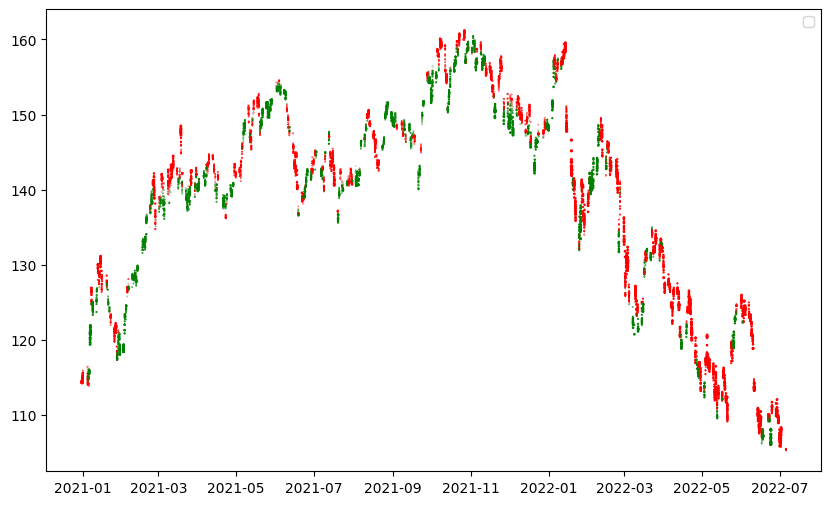

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NVDA
1


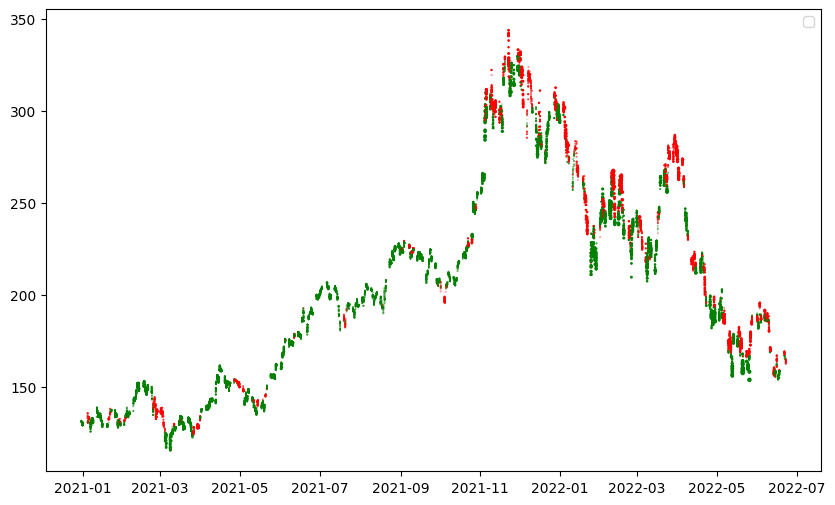

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TSLA
1


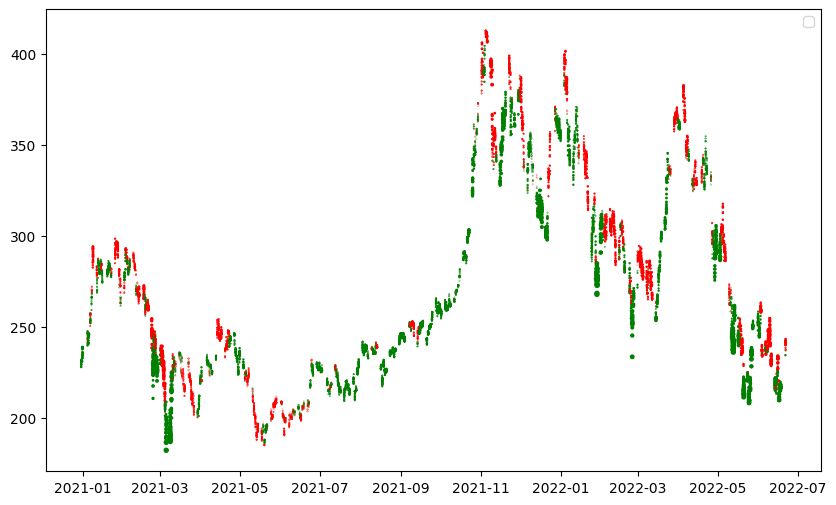

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


VZ
1


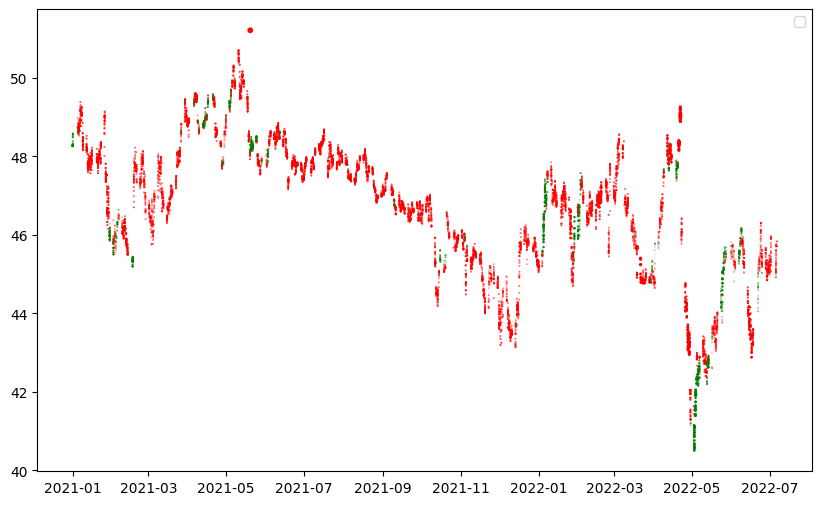

In [18]:
for symbol, symbol_models in models.items():
    print(symbol)
    for name, model in symbol_models.items():
        print(name)
        model.graph_prices(data[symbol]['bars'], .0, 10000, 10)

JPM
1


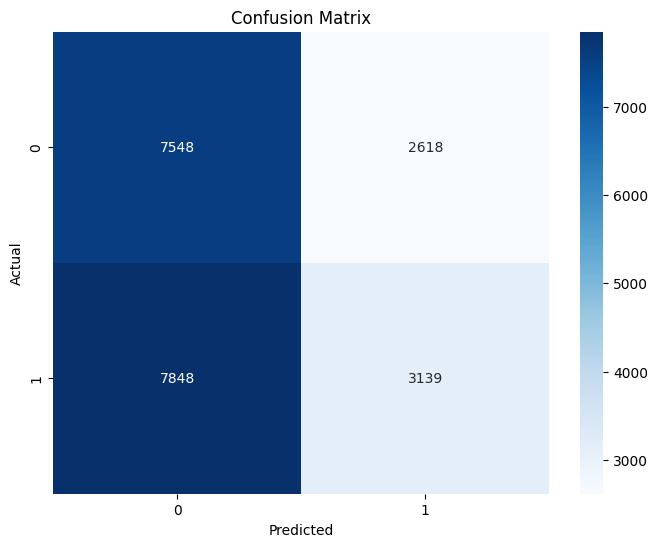

NVDA
1


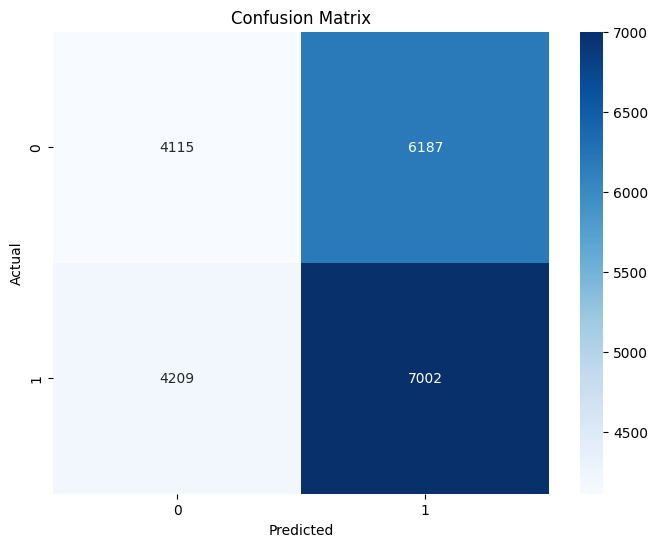

TSLA
1


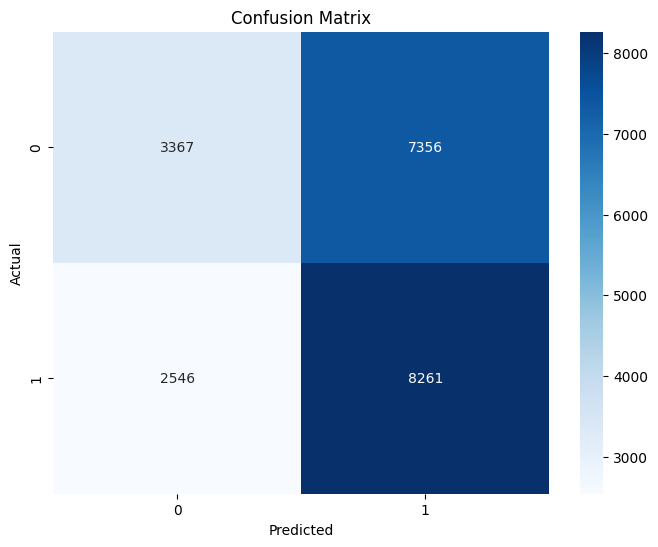

VZ
1


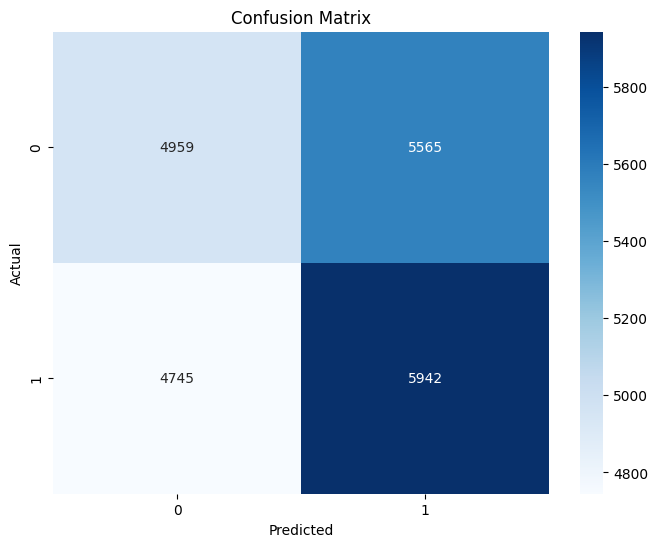

In [25]:
for symbol, symbol_models in models.items():
    print(symbol)
    for name, model in symbol_models.items():
        print(name)
        model.graph_confusion()

In [26]:
class Trade:
    def __init__(self, price, amount, direction, time):
        self.price = price
        self.amount = amount
        self.direction = direction
        self.time = time
        self.returns = 0
        self.gain = 0
        
    def get_gain(self, current_price):
        gain = (current_price/self.price)-1

        #if trade is short, flip
        if self.direction == -1:
            gain *= -1
        self.gain = gain
        return gain

    def get_returns(self):
        returns = self.amount*(1 + self.gain)
        self.returns = returns
        return returns


def simulate(model, dynamic, bank, hold_period, target, stop_loss, trade_size, price_data):
    current_trades = []   
    trades_master = []
    account = []
    bank_list = []
    bank_list.append(bank)
    right = 0
    wrong = 0
    gains=0

    #get predictions from model
    predictions = model.training_data['predicted']

    #set scale factor to scale predictions, scale predictions
    #scale_factor = (trade_size*100)/max(abs(predictions))
    scale_factor = 100/max(abs(predictions))
    predictions = (predictions*scale_factor)

    #get price data
    prices = price_data.values

    #loop over each time period
    account.append(bank)
    for index, prediction in enumerate(predictions):

        #get point's current price
        current_price = prices[index]

        #set max trade size
        max_trade = trade_size*bank

        #set predicted trade direction
        if prediction>0:
            direction = 1
        else:
            direction = -1

        #use prediction to get size of withdraw (higher predictions mean more money per trade=higher withdraw)
        if dynamic:
            prediction = abs(prediction[0])
            money_amount = (max_trade*(prediction/100))
        else:
            money_amount = max_trade * trade_size

        if index==0:
            money_amount=max_trade

        # if index<100:
        #     print("direction: " + str(direction))
        #     print('prediction: ' + str(prediction))
        #     print('bank: ' + str(bank))
        #     print('max_trade: ' + str(max_trade))
        #     print('money_amount: ' + str(money_amount))
        #     print()

        stock_amount = money_amount/current_price

        #withdraw money for trade
        bank -= money_amount

        #create new trade
        new_trade = Trade(price=current_price, amount = money_amount, direction=direction, time=index)
        curr_returns = 0
        
        #go through prexisting trades to possibly sell
        new_current_trades=[]
        cash_equivalent = money_amount
        for i, trade in enumerate(current_trades):

            #get trade's gain as of now
            curr_gain = trade.get_gain(current_price)
            curr_returns = trade.get_returns()

            #if trade is outperforming, underperforming, or has reached its holding period, sell
            if curr_gain > target or curr_gain < stop_loss or trade.time < index - hold_period:

                #sell trade and deposit money
                bank += curr_returns

                #misc; track # of winners and losers
                if curr_gain > 0:
                    right += 1
                else:
                    wrong += 1

                gains += curr_gain
            #if trade is valid, add it to list of current valid trades
            else:
                cash_equivalent += curr_returns
                new_current_trades.append(trade)

        #update current trades to only valid trades
        current_trades = new_current_trades      
        
        #place new trade 
        current_trades.append(new_trade)
        trades_master.append(new_trade)
        
        #add current cash amount to running list to keep track of account performance over time
        bank_list.append(bank)
        account.append(bank + cash_equivalent)

        
    for index, trade in enumerate(current_trades):

        #get trade's return as of now
        curr_returns = trade.get_returns()

        #sell trade and deposit money
        bank += curr_returns
        #misc; track # of winners and losers
        if curr_gain > 0:
            right += 1
        else:
            wrong += 1
        gains += curr_gain

        
    return (bank, bank_list, account, trades_master, right, wrong, gains)
    

JPM
1


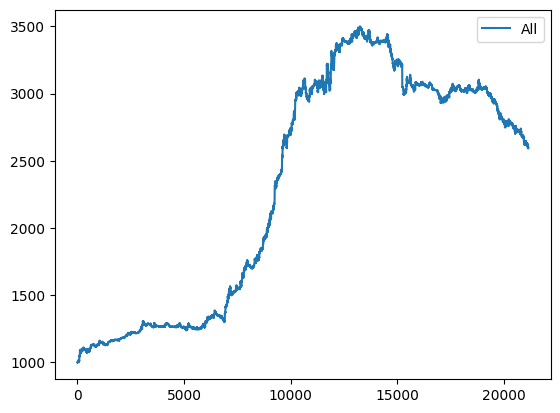

NVDA
1


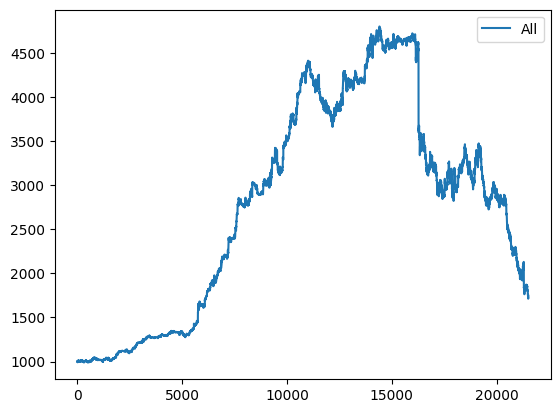

TSLA
1


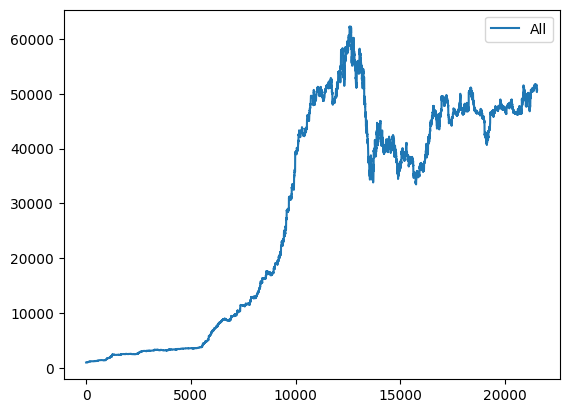

VZ
1


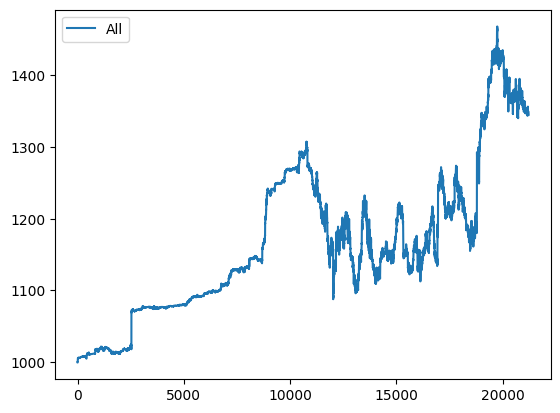

In [27]:
for symbol, symbol_models in models.items():
    print(symbol)
    for name, model_obj in symbol_models.items():    
        bank, bank_list, account, trades_master, right, wrong, gains = simulate(
            model=model_obj, 
            dynamic=True, 
            bank = 1000, 
            hold_period = 15, 
            target = .1, 
            stop_loss = -.01, 
            #trade_size = .05, 
            trade_size = 1,
            price_data = data[symbol]['bars']['open']
        )
        print(name)
        #plt.plot(account[-120252:], label='Year')
        #plt.plot(account[-800:], label='Month')
        #plt.plot(account[-160:], label='Week')
        #plt.plot(account[-32:], label='Day')
        #plt.plot(account[-4:], label='Hour')
        plt.plot(account, label='All')
    
        plt.legend()
        plt.show()



In [ ]:
#Save models
for symbol, model_obj in models.items():

    #make dir string for specific symbol
    symbol_dir = '/Users/davidmutascio/Desktop/models/' + symbol + '/'
    #make directory
    os.makedirs(symbol_dir, exist_ok=True)
    
    # Save the model inside the symbol directory
    model_path = os.path.join(symbol_dir, 'model.pt')
    my_model = model_obj.model[0]

    example = torch.rand(1, 3, 7)
    traced_script_module = torch.jit.trace(my_model, example)
    traced_script_module.save(model_path)


    config_path = os.path.join(symbol_dir, 'config.json')
    with open(config_path, 'w') as json_file:
        json.dump(data[symbol]['config'], json_file)

    #save symbols 
    conn = sqlite3.connect('/Users/davidmutascio/sqlite3_dbs/enigmaDev.db')
    data[symbol]['bars'].to_sql(symbol, conn, if_exists='replace', index=True)
    data[symbol]['features'].to_sql(symbol+'_features', conn, if_exists='replace', index=True)

    
    # Save (commit) the changes
    conn.commit()
    conn.close()

        


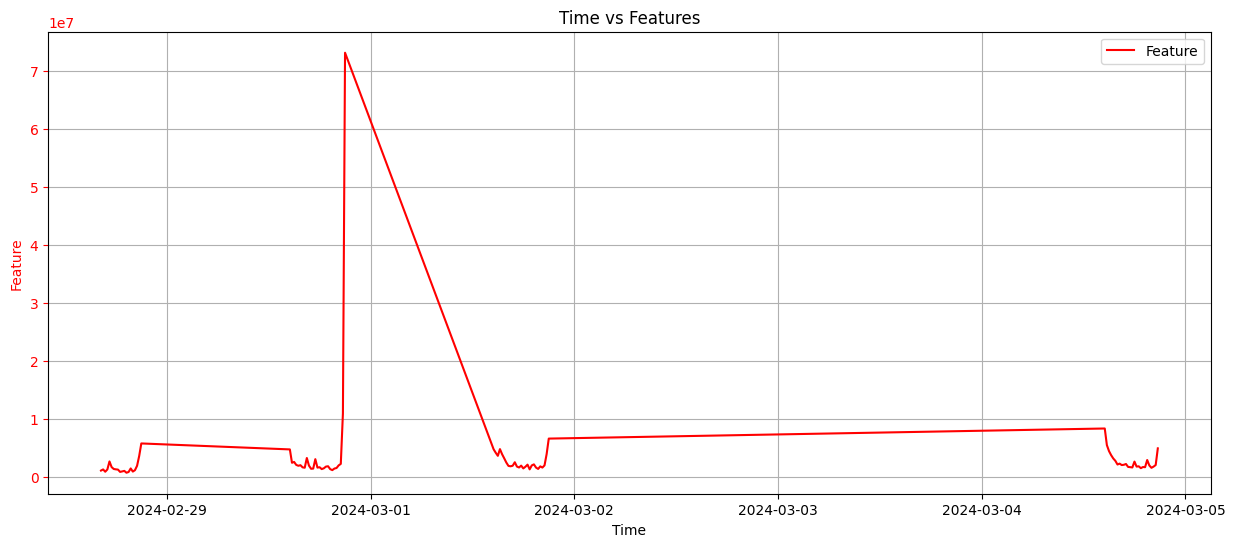

In [33]:
##### graph feature
features = data['AAPL']['features']['Volume'][-100:]
#features2 = data['AAPL']['bars']#[7620:7640]

x=features.index
#y = features
y2 = features
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot the first feature on the main axis
#ax1.scatter(x, y, c='r', marker='o', s=5, label='Feature', edgecolors='none')
ax1.plot(x, y2, color='r', label='Feature')
ax1.set_xlabel('Time')
ax1.set_ylabel('Feature', color='r')
ax1.tick_params('y', colors='r')
ax1.grid(True)

# Create a secondary y-axis
# ax2 = ax1.twinx()

# # Plot the second feature on the secondary y-axis
# #ax2.scatter(x, y2, c='b', marker='o', s=5, label='Price', edgecolors='none')
# ax2.plot(x, y2, color='b', label='Price')
# ax2.set_ylabel('Price', color='b')
# ax2.tick_params('y', colors='b')

# Title for the plot
plt.title('Time vs Features')

# Show the legend
plt.legend()

# Display the plot
plt.show()

In [162]:
print(data['NVDA']['signals'])

                     signal
timestamp                  
2023-10-13 20:22:00     0.0
2023-10-13 20:23:00     0.0
2023-10-13 20:24:00     0.0
2023-10-13 20:25:00     0.0
2023-10-13 20:26:00     0.0
...                     ...
2024-02-23 20:56:00     0.0
2024-02-23 20:57:00     0.0
2024-02-23 20:58:00     0.0
2024-02-23 20:59:00     0.0
2024-02-23 21:00:00     0.0

[35147 rows x 1 columns]


##### conn = sqlite3.connect('/Users/davidmutascio/sqlite3_dbs/enigmaDev.db')
data[symbol]['bars'].to_sql("test", conn, if_exists='replace', index=False)
    
    # Save (commit) the changes
conn.commit()
conn.close()


In [ ]:
#Plot all features
ss = StandardScaler()
X_ss = ss.fit_transform(data['AAPL']['features'])
df_X_ss = pd.DataFrame(X_ss)


for feature_name, feature_data in data['AAPL']['features'].items():
    plt.plot(feature_data, label=feature_name)
plt.legend()
plt.show()

for feature_name, feature_data in df_X_ss.items():
    #if feature_name != 0:
    #    continue
    plt.plot(feature_data, label=feature_name)
    plt.legend()
    plt.show()


In [ ]:
start_time = pd.to_datetime('14:30:00').time()
end_time = pd.to_datetime('21:00:00').time()

filtered_df = data['AAPL']['bars'][
    (data['AAPL']['bars'].index.time >= start_time) & 
    (data['AAPL']['bars'].index.time <= end_time)
]

In [35]:
url = 'https://www.alphavantage.co/query?function=EARNINGS&symbol=AAPL&apikey=8Q9YO46X1BX4DWU1'
r = requests.get(url)
data = r.json()


In [36]:
df = pd.DataFrame(data['quarterlyEarnings']).set_index('fiscalDateEnding').rename(columns = {'reportedEPS': 'EPS'})


# Print the DataFrame
print(df)

                 reportedDate     EPS estimatedEPS surprise surprisePercentage
fiscalDateEnding                                                              
2023-12-31         2024-02-01    2.18          2.1     0.08             3.8095
2023-09-30         2023-11-02    1.46         1.39     0.07              5.036
2023-06-30         2023-08-03    1.26         1.19     0.07             5.8824
2023-03-31         2023-05-04    1.52         1.43     0.09             6.2937
2022-12-31         2023-02-02    1.88         1.94    -0.06            -3.0928
...                       ...     ...          ...      ...                ...
1997-03-31         1997-04-16   -0.05        -0.04    -0.01                -25
1996-12-31         1997-01-15   -0.03        -0.02    -0.01                -50
1996-09-30         1996-10-16  0.0018        -0.01   0.0118                118
1996-06-30         1996-07-17   -0.02        -0.04     0.02                 50
1996-03-31         1996-04-17   -0.07        -0.05  

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (100,) and arg 1 with shape (12,).

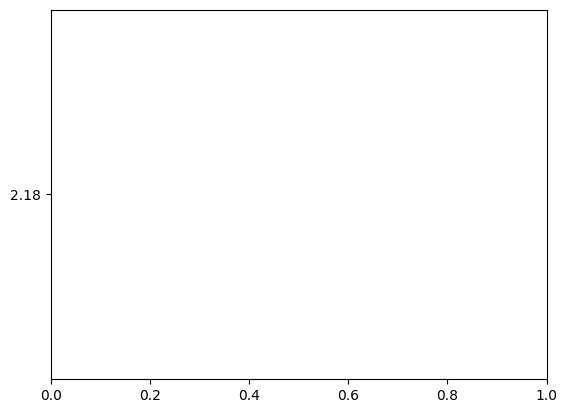

In [53]:
plt.bar(range(1, 100+1), df['EPS'][:-100])
plt.xlabel('Months')
plt.ylabel('EPS')
plt.title('EPS for the First 12 Months')
plt.show()

###### 